In [113]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [114]:
data_train = pd.read_csv("Train-2a-25.csv")
data_test = pd.read_csv("Test-50.csv")
data_validation = pd.read_csv("Val-50.csv")

display(data_train.shape)
display(data_test.shape)
display(data_validation.shape)

(25, 3)

(50, 3)

(39, 3)

In [115]:
data_train.head()

,x1,x2,output
0,1.785714,-0.821429,5235.801136
1,-1.160714,1.678571,5540.341626
2,-1.982143,1.178571,-932.480848
3,1.875000,0.464286,11886.466102
4,-0.535714,1.750000,7331.723341


In [116]:
output_name = "output"
t_train = data_train[output_name]
t_test = data_test[output_name]
t_validation = data_validation[output_name]
t_train = t_train.values
t_test = t_test.values
t_validation = t_validation.values

In [117]:
x_train = data_train.drop(output_name, axis=1)
x_test = data_test.drop(output_name, axis=1)
x_validation = data_validation.drop(output_name, axis=1)
x_train = x_train.values
x_test = x_test.values
x_validation = x_validation.values

In [118]:
def generate_polynomial_basis(M):
    basis_functions = []
    for degree in range(M + 1):
        for exponents in itertools.product(range(degree + 1), repeat=len(x_train[0])):
            if sum(exponents) == degree:
                basis_functions.append(exponents)

    return basis_functions

In [119]:
def generate_design_matrix(X, basis_functions):
    n_samples, n_variables = X.shape

    # Initialize the design matrix
    design_matrix = np.ones((n_samples, len(basis_functions)))

    # Populate the design matrix
    for i, exponents in enumerate(basis_functions):
        term = np.prod([X[:, j]**exponents[j] for j in range(n_variables)], axis=0)
        design_matrix[:, i] = term

    return design_matrix

In [120]:
def estimate_parameters(Phi, t, λ):
    d = Phi.shape[1]
    I = np.eye(d)
    # Estimate the coefficients using: (Phi.T * Phi)^-1 * Phi.T * y
    x = np.linalg.inv((Phi.T @ Phi) + λ*I)  # Inverse of Phi^T * X
    y = Phi.T @ t  # Phi^T * t
    w = x @ y  # (Phi^T * Phi)^-1 * Phi^T * t

    return w

In [121]:
t_train.shape

(25,)

In [122]:
def fit(x_train, t_train, M, λ=0):
  basis_functions = generate_polynomial_basis(M)
  Phi = generate_design_matrix(x_train, basis_functions)
  w = estimate_parameters(Phi, t_train, λ)
  return Phi, w

In [123]:
def predict(X, w, M):
    X = np.asarray(X)
    basis_functions = generate_polynomial_basis(M)
    X_design = generate_design_matrix(X, basis_functions)
    y_pred = X_design @ w
    return y_pred

In [124]:
def Erms(y, t):
    return np.sqrt(sum((y - t)**2) / len(t))

In [125]:
from sklearn.metrics import r2_score

def calculate_accuracy(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [126]:
def plot_predict_actual(y, t, M, λ=0):
  # Plotting actual vs predicted values
  plt.figure(figsize=(5, 3))
  plt.scatter(t, y, color='blue', label='Predicted vs Actual')

  # Plotting a diagonal line for reference (perfect prediction line)
  plt.plot([min(t), max(t)], [min(t), max(t)], color='red', linestyle='--', label='Perfect Prediction')

  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title(f'Predicted vs Actual Values for Degree={M}, λ={λ}')
  plt.legend()
  plt.show()

In [127]:
def plot_curve(w, M, λ=0):
  x_plot = np.linspace(min(np.concatenate((x_train, x_validation, x_test))),
                      max(np.concatenate((x_train, x_validation, x_test))), 100)
  y_plot = predict(x_plot, w, M)

  # Plotting actual vs predicted values
  plt.figure(figsize=(10, 6))
  plt.scatter(x_train, t_train, color='red', label='Train Data')
  plt.scatter(x_test, t_test, color='blue', label='Test Data')
  plt.scatter(x_validation, t_validation, color='black', label='Validation Data')
  plt.plot(x_plot, y_plot, color='green', label='Curvfitting')

  # plt.xlim(min(x_train)-0.2, max(x_train)+0.2)  # x-axis limits from 0 to 6
  # plt.ylim(min(t_train)-1, max(t_train)+1)  # y-axis limits from 0 to 30

  plt.xlabel('X Data')
  plt.ylabel('Y Output')
  plt.title(f'Polynomial Curve Fitting for Dataset 1 Degree={M}, λ={λ}')
  plt.legend()
  plt.show()


M = 2: Train Data Erms = 1575.0680979719841, Train Data Accuracy = 0.82037058138647
M = 2: Test Data Erms = 3094.679153956033, Test Data Accuracy = 0.7503987618970279
M = 4: Train Data Erms = 72.22881545962359, Train Data Accuracy = 0.9996222540828911
M = 4: Test Data Erms = 3383.840377631962, Test Data Accuracy = 0.7015749928436538
M = 6: Train Data Erms = 2937.454441582628, Train Data Accuracy = 0.3752286972957375
M = 6: Test Data Erms = 10059.441234728814, Test Data Accuracy = -1.637322209739255


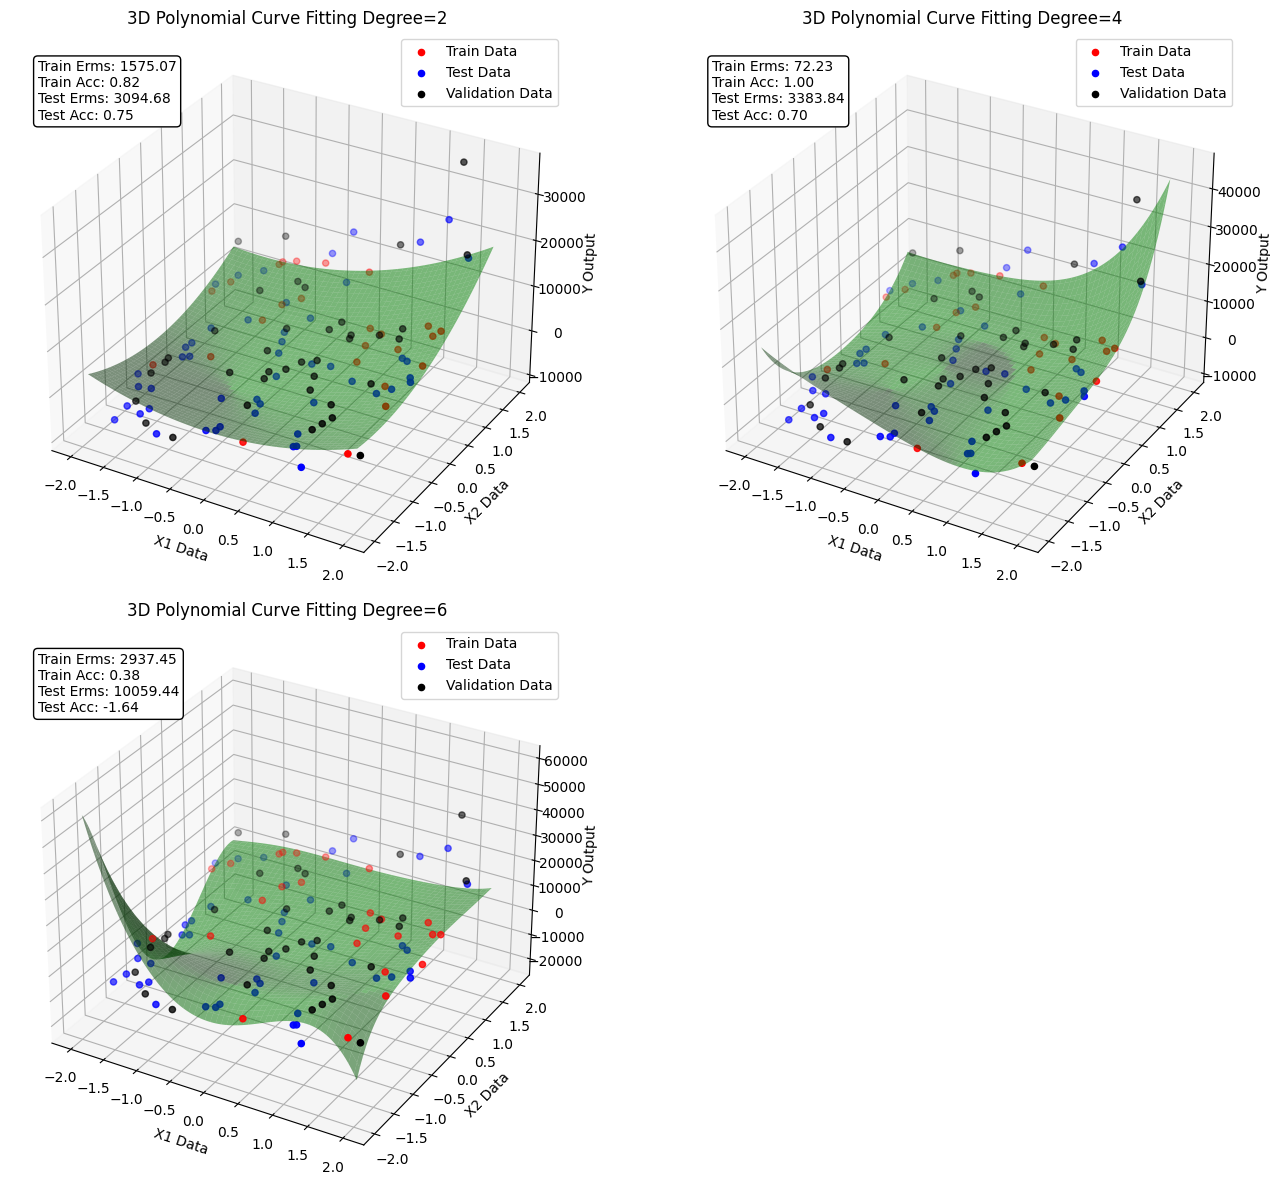

In [128]:
#Without Regularization
M_values = [2, 4, 6]

n_cols = 2
n_rows = (len(M_values) + n_cols - 1) // n_cols  # This will give you the ceiling of len(M_values) / n_cols

# Setting up the plot with two columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 6), subplot_kw={'projection': '3d'})

# Flattening the axes array only if it is multidimensional
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i, M in enumerate(M_values):
    # Train the model
    Phi, w = fit(x_train, t_train, M)

    # Model Performance analysis on Train data
    y_train = predict(x_train, w, M)
    accuracy_train = calculate_accuracy(t_train, y_train)
    Erms_train = Erms(y_train, t_train)

    # Model Performance analysis on Test data
    y_test = predict(x_test, w, M)
    accuracy_test = calculate_accuracy(t_test, y_test)
    Erms_test = Erms(y_test, t_test)

    print(f"M = {M}: Train Data Erms = {Erms_train}, Train Data Accuracy = {accuracy_train}")
    print(f"M = {M}: Test Data Erms = {Erms_test}, Test Data Accuracy = {accuracy_test}")

    # Generate a meshgrid for plotting
    x1_range = np.linspace(min(x_train[:, 0]), max(x_train[:, 0]), 100)
    x2_range = np.linspace(min(x_train[:, 1]), max(x_train[:, 1]), 100)
    x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)
    x_plot = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]

    y_plot = predict(x_plot, w, M)
    y_plot = y_plot.reshape(x1_mesh.shape)

    # Plotting actual vs predicted values
    axes[i].scatter(x_train[:, 0], x_train[:, 1], t_train, color='red', label='Train Data')
    axes[i].scatter(x_test[:, 0], x_test[:, 1], t_test, color='blue', label='Test Data')
    axes[i].scatter(x_validation[:, 0], x_validation[:, 1], t_validation, color='black', label='Validation Data')
    axes[i].plot_surface(x1_mesh, x2_mesh, y_plot, color='green', alpha=0.5)

    # Adding Erms and accuracy as text on the plot at the top-right position
    text_str = (
        f"Train Erms: {Erms_train:.2f}\n"
        f"Train Acc: {accuracy_train:.2f}\n"
        f"Test Erms: {Erms_test:.2f}\n"
        f"Test Acc: {accuracy_test:.2f}"
    )
    axes[i].text2D(0.05, 0.95, text_str, transform=axes[i].transAxes, fontsize=10,
                   verticalalignment='top', horizontalalignment='left',
                   bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    axes[i].set_xlabel('X1 Data')
    axes[i].set_ylabel('X2 Data')
    axes[i].set_zlabel('Y Output')
    axes[i].set_title(f'3D Polynomial Curve Fitting Degree={M}')
    axes[i].legend()

# Hide any unused subplots
for j in range(len(M_values), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


M = 6: Train Data Erms (No Reg) = 2937.454441582628, Train Data Accuracy (No Reg) = 0.3752286972957375
M = 6: Test Data Erms (No Reg) = 10059.441234728814, Test Data Accuracy (No Reg) = -1.637322209739255
M = 6: Train Data Erms (Reg) = 8.445709310927992, Train Data Accuracy (Reg) = 0.999994835229205
M = 6: Test Data Erms (Reg) = 1450.5792477155892, Test Data Accuracy (Reg) = 0.9451598800015003
M = 6: Train Data Erms (No Reg) = 2937.454441582628, Train Data Accuracy (No Reg) = 0.3752286972957375
M = 6: Test Data Erms (No Reg) = 10059.441234728814, Test Data Accuracy (No Reg) = -1.637322209739255
M = 6: Train Data Erms (Reg) = 14.151371033523919, Train Data Accuracy (Reg) = 0.999985499738665
M = 6: Test Data Erms (Reg) = 1575.7035241672963, Test Data Accuracy (Reg) = 0.9352910297089554
M = 6: Train Data Erms (No Reg) = 2937.454441582628, Train Data Accuracy (No Reg) = 0.3752286972957375
M = 6: Test Data Erms (No Reg) = 10059.441234728814, Test Data Accuracy (No Reg) = -1.637322209739255


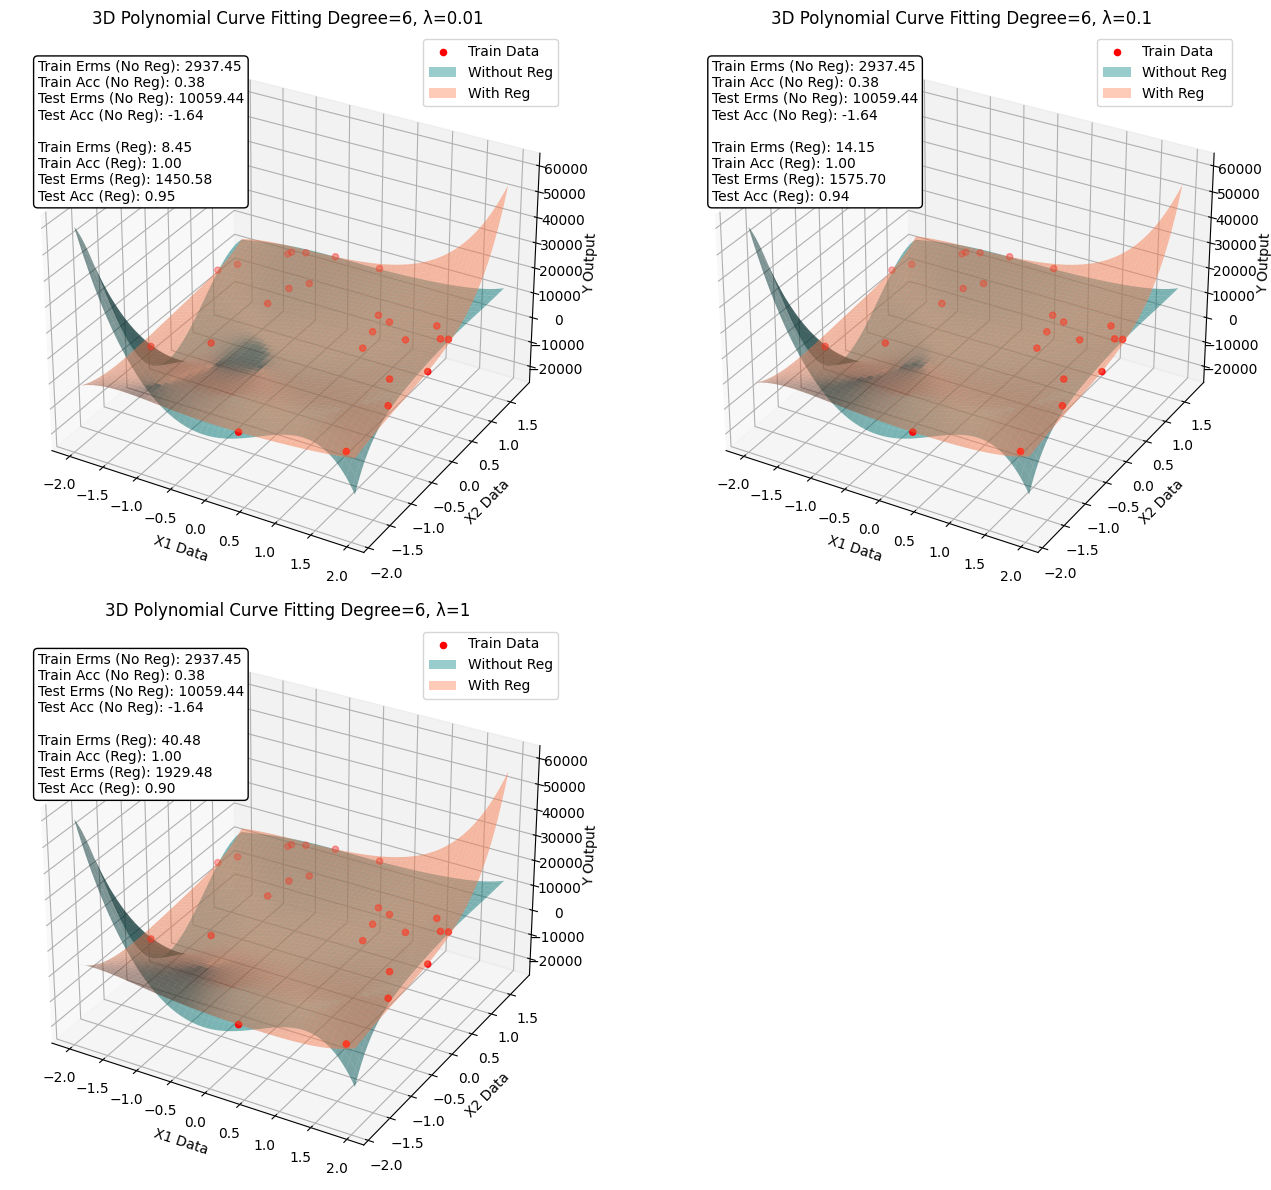

In [142]:
# Define the range of polynomial degrees (M) and regularization parameter (lambda)
M = 6
λ_values = [0.01, 0.1, 1]

n_cols = 2
n_rows = (len(M_values) + n_cols - 1) // n_cols  # Ceiling of len(M_values) / n_cols

# Setting up the plot with two columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 6), subplot_kw={'projection': '3d'})

# Flattening the axes array only if it is multidimensional
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i, λ in enumerate(λ_values):
    # Train the model without and with regularization
    Phi, w = fit(x_train, t_train, M)
    Phi_with_Reg, w_with_reg = fit(x_train, t_train, M, λ)

    # Model Performance analysis on Train data without Regularization
    y_train = predict(x_train, w, M)
    accuracy_train = calculate_accuracy(t_train, y_train)
    Erms_train = Erms(y_train, t_train)

    # Model Performance analysis on Test data without Regularization
    y_test = predict(x_test, w, M)
    accuracy_test = calculate_accuracy(t_test, y_test)
    Erms_test = Erms(y_test, t_test)

    # Model Performance analysis on Train data with Regularization
    y_train_with_reg = predict(x_train, w_with_reg, M)
    accuracy_train_with_reg = calculate_accuracy(t_train, y_train_with_reg)
    Erms_train_with_reg = Erms(y_train_with_reg, t_train)

    # Model Performance analysis on Test data with Regularization
    y_test_with_reg = predict(x_test, w_with_reg, M)
    accuracy_test_with_reg = calculate_accuracy(t_test, y_test_with_reg)
    Erms_test_with_reg = Erms(y_test_with_reg, t_test)

    print(f"M = {M}: Train Data Erms (No Reg) = {Erms_train}, Train Data Accuracy (No Reg) = {accuracy_train}")
    print(f"M = {M}: Test Data Erms (No Reg) = {Erms_test}, Test Data Accuracy (No Reg) = {accuracy_test}")
    print(f"M = {M}: Train Data Erms (Reg) = {Erms_train_with_reg}, Train Data Accuracy (Reg) = {accuracy_train_with_reg}")
    print(f"M = {M}: Test Data Erms (Reg) = {Erms_test_with_reg}, Test Data Accuracy (Reg) = {accuracy_test_with_reg}")

    # Generate a meshgrid for plotting
    x1_range = np.linspace(min(x_train[:, 0]), max(x_train[:, 0]), 100)
    x2_range = np.linspace(min(x_train[:, 1]), max(x_train[:, 1]), 100)
    x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)
    x_plot = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]

    # Predict the output for both regularized and non-regularized models
    y_plot = predict(x_plot, w, M)
    y_plot_with_reg = predict(x_plot, w_with_reg, M)

    y_plot = y_plot.reshape(x1_mesh.shape)
    y_plot_with_reg = y_plot_with_reg.reshape(x1_mesh.shape)

    # Plotting actual vs predicted values
    train_data_scatter = axes[i].scatter(x_train[:, 0], x_train[:, 1], t_train, color='red', label='Train Data')
    surface_no_reg = axes[i].plot_surface(x1_mesh, x2_mesh, y_plot, color='teal', alpha=0.5)
    surface_with_reg = axes[i].plot_surface(x1_mesh, x2_mesh, y_plot_with_reg, color='coral', alpha=0.5)

    # Adding a custom legend
    axes[i].legend([train_data_scatter], ['Train Data'], loc='upper right')
    surface_proxy_no_reg = plt.Rectangle((0, 0), 1, 1, fc="teal", alpha=0.4)
    surface_proxy_with_reg = plt.Rectangle((0, 0), 1, 1, fc="coral", alpha=0.4)
    axes[i].legend([train_data_scatter, surface_proxy_no_reg, surface_proxy_with_reg],
                   ['Train Data', 'Without Reg', 'With Reg'], loc='upper right')

    # Adding Erms and accuracy as text on the plot at the top-right position
    text_str = (
        f"Train Erms (No Reg): {Erms_train:.2f}\n"
        f"Train Acc (No Reg): {accuracy_train:.2f}\n"
        f"Test Erms (No Reg): {Erms_test:.2f}\n"
        f"Test Acc (No Reg): {accuracy_test:.2f}\n\n"
        f"Train Erms (Reg): {Erms_train_with_reg:.2f}\n"
        f"Train Acc (Reg): {accuracy_train_with_reg:.2f}\n"
        f"Test Erms (Reg): {Erms_test_with_reg:.2f}\n"
        f"Test Acc (Reg): {accuracy_test_with_reg:.2f}"
    )
    axes[i].text2D(0.05, 0.95, text_str, transform=axes[i].transAxes, fontsize=10,
                   verticalalignment='top', horizontalalignment='left',
                   bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    axes[i].set_xlabel('X1 Data')
    axes[i].set_ylabel('X2 Data')
    axes[i].set_zlabel('Y Output')
    axes[i].set_title(f'3D Polynomial Curve Fitting Degree={M}, λ={λ}')

# Hide any unused subplots
for j in range(len(λ_values), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Train Data Erms: 276.0108835609366
Train Data Accuracy: 0.9944839117142557
Test Data Erms: 1150.1622893950992
Test Data Accuracy: 0.9655226621453532
Validation Data Erms: 1916.2092660427306
Validation Data Accuracy: 0.927354904886075
Train Data:


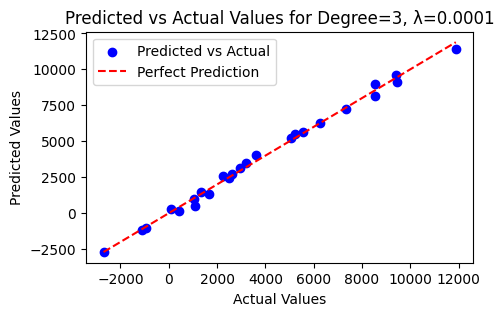

Test Data:


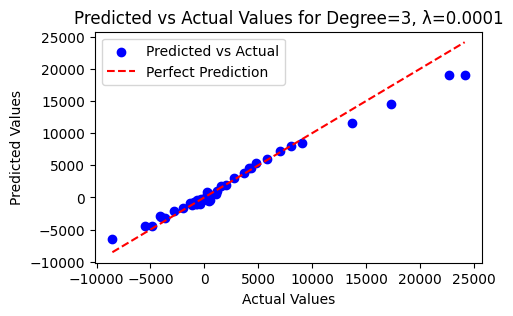

Validation Data:


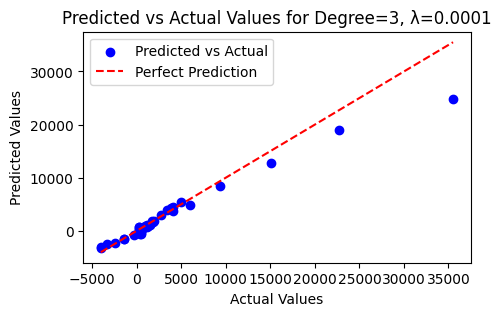

In [130]:
#Hyperparameter
#Highest Degree
M=3
λ=0.0001

#Train The Model
Phi, w = fit(x_train, t_train, M, λ)


#Model Performance analysis on Train data
y_train = predict(x_train, w, M)
accuracy_train=calculate_accuracy(t_train, y_train)
Erms_train = Erms(y_train, t_train)

print(f"Train Data Erms: {Erms_train}")
print(f"Train Data Accuracy: {accuracy_train}")


#Model Performance analysis on Test data
y_test = predict(x_test, w, M)
accuracy_test=calculate_accuracy(t_test, y_test)
Erms_test = Erms(y_test, t_test)

print(f"Test Data Erms: {Erms_test}")
print(f"Test Data Accuracy: {accuracy_test}")


#Model Performance analysis on Validation data
y_validation = predict(x_validation, w, M)
accuracy_validation=calculate_accuracy(t_validation, y_validation)
Erms_validation = Erms(y_validation, t_validation)

print(f"Validation Data Erms: {Erms_validation}")
print(f"Validation Data Accuracy: {accuracy_validation}")

#Visualization of Model

print("Train Data:")
plot_predict_actual(y_train, t_train, M, λ)

print("Test Data:")
plot_predict_actual(y_test, t_test, M, λ)

print("Validation Data:")
plot_predict_actual(y_validation, t_validation, M, λ)